# Unsupervised Learning

General idea: give an ML model a bunch of images of working and defective products, but don't give it the working/not working labels.

Unsupervised tasks:
- Dimensionality Reduction (ch7)
- Clustering - recommendations, search engines, dimensionality reduction. 
- Anomaly Detection - learn what "normal" is, then use that to find not normal. Good for fraud/defective detection, time series trends, removing outliers (GREAT for data cleaning)
- Density Estimation - estimating pdf of random process that made the dataset


## Clustering: k means and DBSCAN

useful clustering applications: customer segmentation, data analysis, dimensionality reduction, feature engineering, anomaly detection, semi-supervised learning, search engines, image segmentation

### k means clustering

In [1]:
# boilerplate
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

X, y, cens= make_blobs(500, centers = 5, return_centers=True)
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
yPred = kmeans.fit_predict(X)
yPred is kmeans.labels_

c:\Users\willh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


True

In [2]:
kmeans.cluster_centers_

array([[ 9.82045181, -8.51157894],
       [ 6.67605764,  2.62659704],
       [-4.55655473,  3.49037541],
       [-1.37721462,  2.53641895],
       [-5.54214983,  2.17536032]])

Hard clustering: assign each new instance to a cluster

Soft clustering: give %s that an instance is in each cluster

#### k means algorithm

1) randomly guess n centroids
2) label every instance with the centroid
3) update centroids to their instances means
4) repeat 2-3-4

This converges, but might not be right. Might end up with 2 centroids fitting 1 blob and 1 centroid fitting 2 blobs.

##### Centroid initialization methods

If you have an idea with the centroids should be:

In [11]:
import numpy as np
goodInit = np.array([[3,3], [-1,5], [6,7], [9,-4], [1,1]])
# my init is random and probably actually bad
kmeans = KMeans(n_clusters=5, init=goodInit)
kmeans.fit(X)

# kmeans.inertia_

c:\Users\willh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


KMeans(init=array([[ 3,  3],
       [-1,  5],
       [ 6,  7],
       [ 9, -4],
       [ 1,  1]]),
       n_clusters=5)

You could also just run the algo multiple times and keep the best solution. Number of random initializations is controlled by `n_init`. Scikitlearn does 10, and keeps the best with a models *inertia*

$\text{inertia} = \sum_{i=1}^{m} \left\| \mathbf{x}^{(i)} - {c^{(i)}} \right\|^2$

Inertia is the sum of all distances between x^i and the closest centroid c^i

Sklearn uses a k-means++ algorithm that tends to choose random centroids that are further away from each other, which is proven to converge more quickly/reliably. 

### Accelerated k-means and mini batch k-means

For big datasets with lots of clusters, you can accelerate kmeans by keeping track of lower/upper bounds for distances btwn centroids and instances. This doesnt always help, might even hurt. but you can set `algorithm="elkan"`

Mini batch: Instead of using every data point at each iteration, just use small batches of data and move centroids a little bit.

In [6]:
from sklearn.cluster import MiniBatchKMeans
mini = MiniBatchKMeans(n_clusters=5)
mini.fit(X)

c:\Users\willh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1972: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(


MiniBatchKMeans(n_clusters=5)

#### Finding optimal n clusters

You cant just optimize for inertia because more centroids = lower inertia.

Silhouette score: mean silhouette coefficient over all instaces. Coefficient for each instance = (b-a) / max(a,b) where a is mean distance to all instances in same cluster, and b is the mean nearest cluster distance (avg distance to instances in next closest cluster)

Coefficient of 1 means an instance is firmly inside its own cluster and far from other cluster. -1 means the instance is probably not in the right cluster.

In [12]:
from sklearn.metrics import silhouette_score
silhouette_score(X, kmeans.labels_)

0.537752658155355

If you plot every instances silhoutte coefficient, sorted by clusters and value of coefficient, you get a silhouette diagram. Looks like a knife plot. If you plot the average silhoutte score across all instances as a vertical line, the very best n clusters will tend to be very uniform and all poking past the mean.

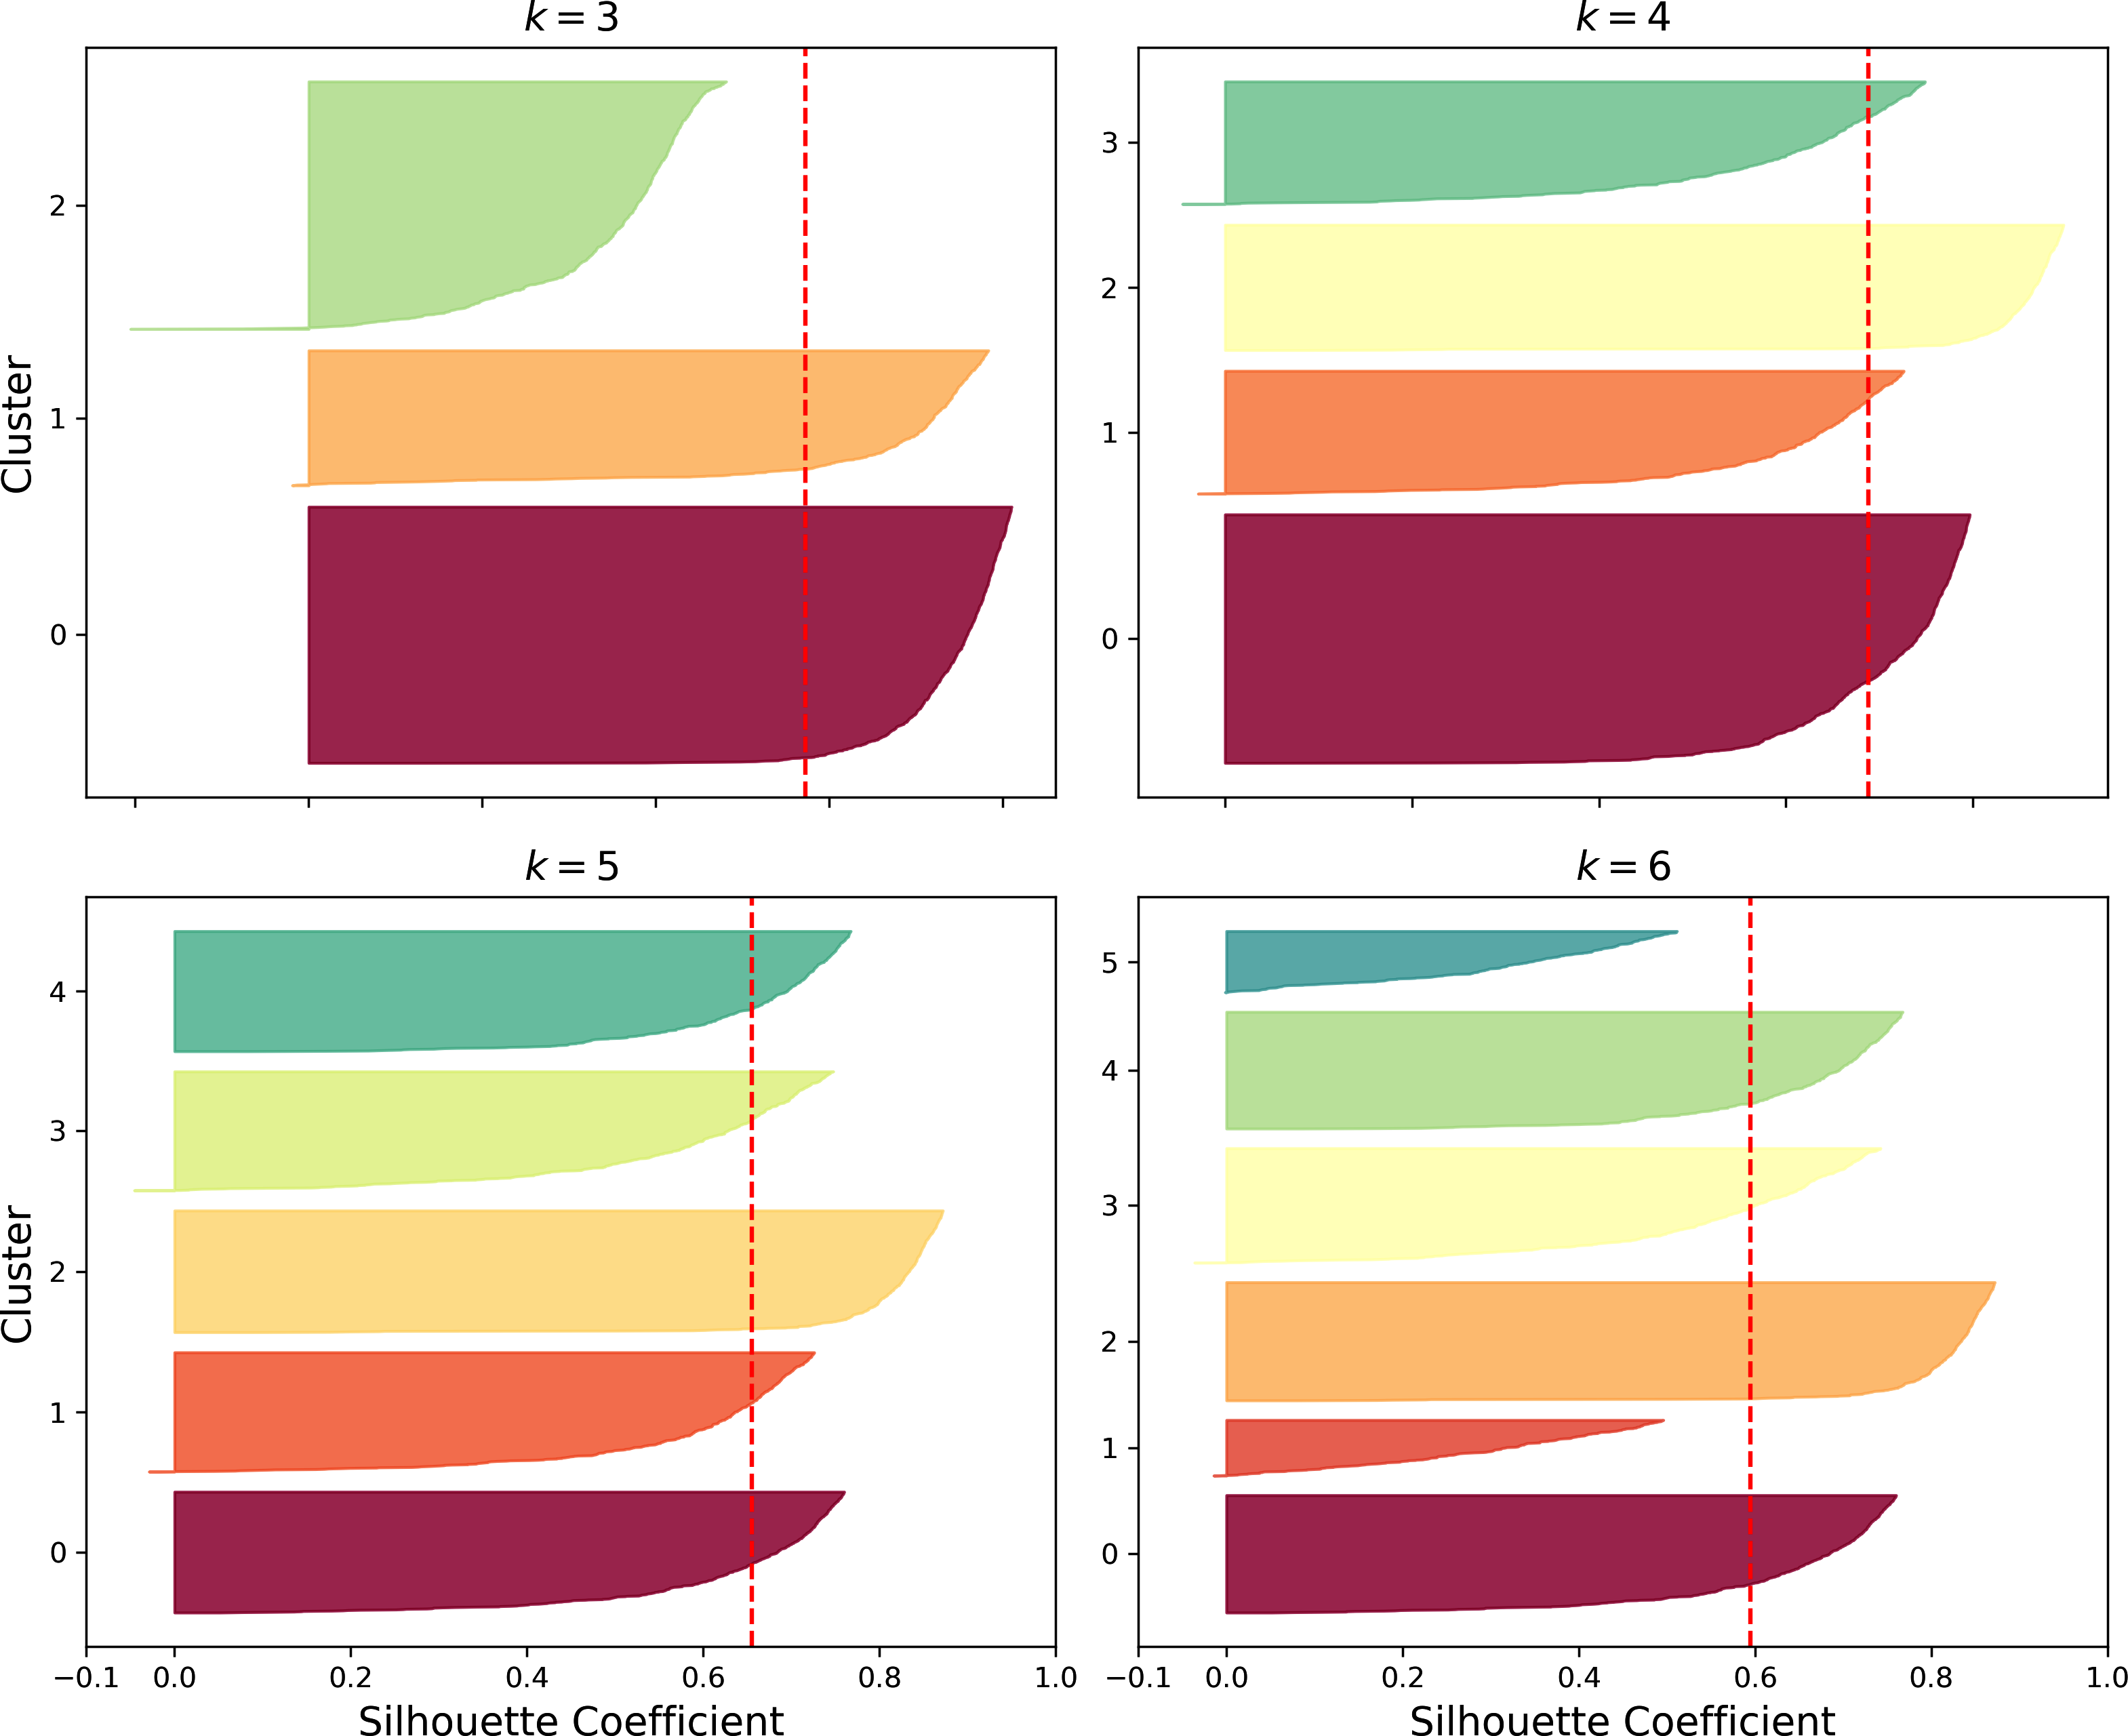

### Limits of k-means

Its fast, but you need to run it multiple times, and specify the number of clusters. It also doesnt do very well on noncircular clusters

Scaling features can help k-means a lot, so make sure you do that if you want kmeans to work well.

## Clustering for Image Segmentation

Image segmentation: break image into multiple parts

- color segmentation: group pixels by color. good for satellite data
- semantic segmentation: all pixels apart of the same object type get grouped (ie a self driving car makes one pedestrian blob)
- instance segmentation: all pixels apart of one object get grouped (one segment per pedestrian)

In [ ]:
from PIL import Image
img = Image.open("datasets/ladybug.jpg")
image = np.asarray(img.resize((img.width // 8, img.height // 8)))
image.shape
# 3 is the rgb colors

(456, 684, 3)

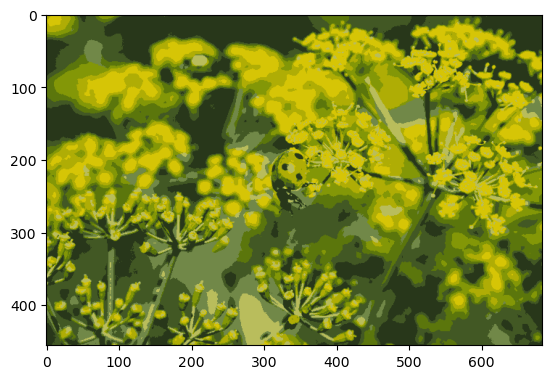

In [31]:
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8).fit(X)
segmented = kmeans.cluster_centers_[kmeans.labels_]
segmented = segmented.reshape(image.shape)

import matplotlib.pyplot as plt
plt.imshow(segmented.astype(np.uint8))
plt.show()

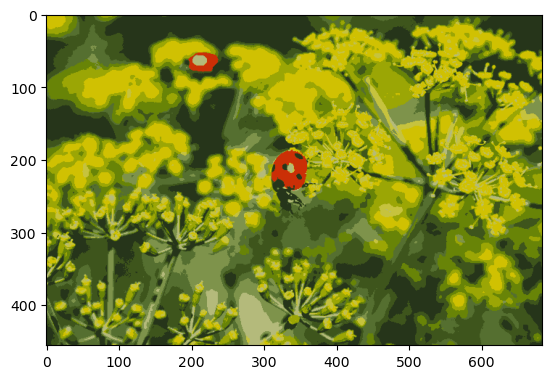

In [34]:
kmeans = KMeans(n_clusters=10).fit(X)
segmented = kmeans.cluster_centers_[kmeans.labels_]
segmented = segmented.reshape(image.shape)

import matplotlib.pyplot as plt
plt.imshow(segmented.astype(np.uint8))
plt.show()

## Clustering and Semi-Supervised Learning

Semi supervised: lots of data, few labels

In [36]:
from sklearn.datasets import load_digits

Xdigits, ydigits = load_digits(return_X_y=True)
Xtrain, ytrain = Xdigits[:1400], ydigits[:1400]
Xtest, ytest = Xdigits[1400:], ydigits[1400:]

In [ ]:
# Pretend you only have 50 labels
from sklearn.linear_model import LogisticRegression
nLabels = 50
logReg = LogisticRegression(max_iter=10000)
logReg.fit(Xtrain[:nLabels], ytrain[:nLabels])
logReg.score(Xtest,ytest)
# 50 instances simply isnt enough to train on

0.7581863979848866

Do better by clustering, then find image closest to each centroid

In [44]:
k=50
kmeans = KMeans(n_clusters=k, random_state=42)
XdigitsDist = kmeans.fit_transform(Xtrain)
repDigitsIdxs = XdigitsDist.argmin(axis=0)
XrepDigits = Xtrain[repDigitsIdxs]
XrepDigits[0].reshape(8,8)
# you can actually visualize this and see its an 8

c:\Users\willh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


array([[ 0.,  0.,  0.,  7., 13.,  8.,  0.,  0.],
       [ 0.,  0.,  2., 16.,  8., 15.,  0.,  0.],
       [ 0.,  0.,  4., 12.,  8., 11.,  0.,  0.],
       [ 0.,  0.,  2., 16., 16.,  3.,  0.,  0.],
       [ 0.,  0.,  5., 16., 16.,  2.,  0.,  0.],
       [ 0.,  2., 16.,  7.,  9., 11.,  0.,  0.],
       [ 0.,  0.,  9., 12.,  1., 14.,  6.,  0.],
       [ 0.,  0.,  0.,  6., 15., 15., 12.,  0.]])